1. Here I am trying to implement the [Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network](http://https://arxiv.org/pdf/1609.05158.pdf) paper on medical chest X-ray images.

2. Here authors have proposed sub-pixel convolution layer which learns an array of upscaling filters to upscale the final Low Resolution feature maps into the High Resolution output. This effectively helps to eliminate bicubic filter in the Super Resolution pipeline with more complex upscaling filters specifically trained for each feature map, whilst also reducing the computational complexity of the overall Super Resolution operation. 

In [1]:
# Import all the necessary libraries

import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse

from IPython.display import display

### Define image data generators to load and preprocess the images

In [2]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8
root_dir = '../input/bt-dataset/processed_images/'

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 994 files belonging to 3 classes.
Using 796 files for training.
Found 994 files belonging to 3 classes.
Using 198 files for validation.


### Normalize the pixels for training and validation images

In [3]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

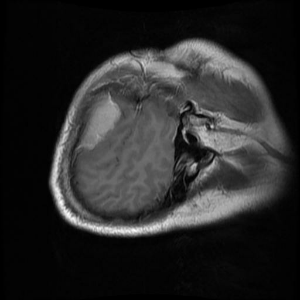

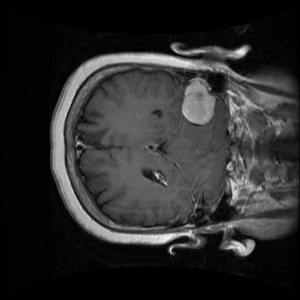

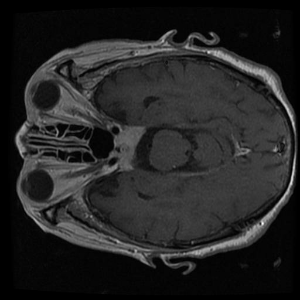

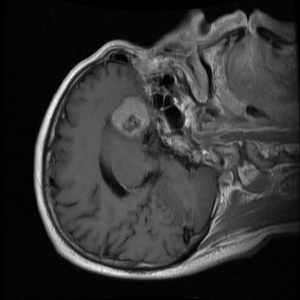

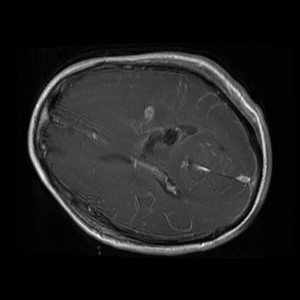

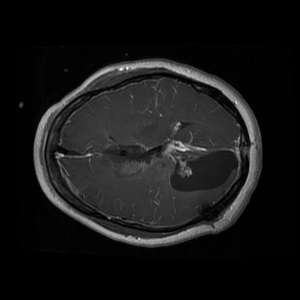

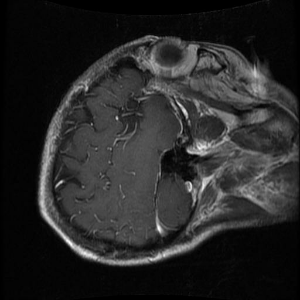

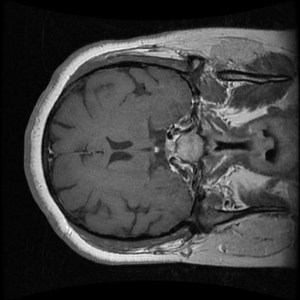

In [4]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

### Here we have prepared a dataset of test image paths that we will use for visual evaluation at the end of this example.

In [5]:
test_path = os.path.join(root_dir, "test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpeg")
    ]
)


### Here we define functions to process the input images.

1. First, we convert our images from the RGB color space to the YUV colour space.
2. We take input data (low-resolution images), we crop the image, retrieve the y channel (luninance), and resize it. We only consider the luminance channel in the YUV color space because humans are more sensitive to luminance change.
3. For the target data (high-resolution images), we just crop the image and retrieve the y channel.

In [6]:
# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

### Visualize input images after processing them. And we will also look into target images

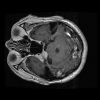

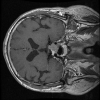

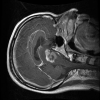

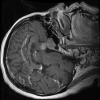

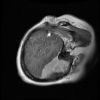

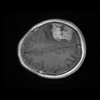

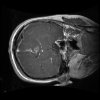

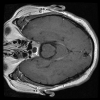

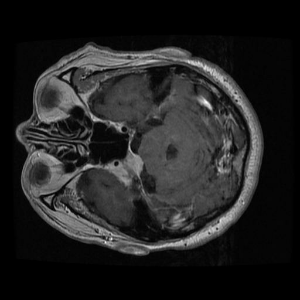

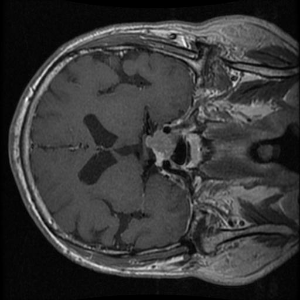

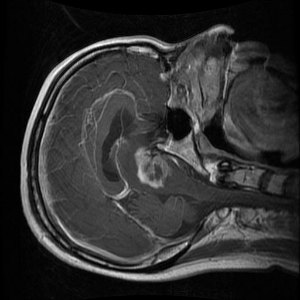

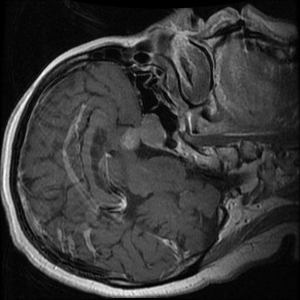

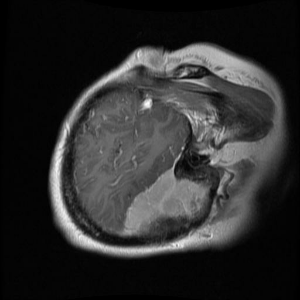

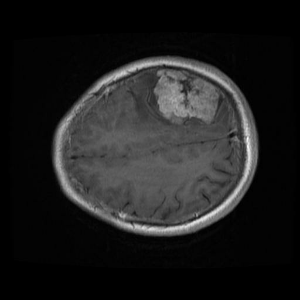

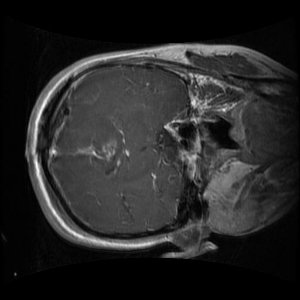

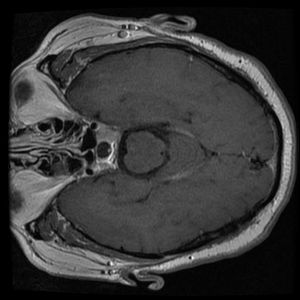

In [7]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

### Define Our CNN Model Architecture

In [8]:
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

### Here we have defined some utility functions to monitor our results

1. plot_results to plot an save an image.
2. get_lowres_image to convert an image to its low-resolution version.
3. upscale_image to turn a low-resolution image to a high-resolution version reconstructed by the model. In this function, we use the y channel from the YUV color space as input to the model and then combine the output with the other channels to obtain an RGB image.

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

### Here we have defined callbacks to monitor training

1. The ESPCNCallback object will compute and display the PSNR metric. 
2. This is the main metric we use to evaluate super-resolution performance.

In [10]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []
        
    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [11]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 9)     2601      
_________________________________________________________________
tf_op_layer_DepthToSpace (Te [(None, None, None, 1)]   0         
Total params: 59,657
Trainable params: 59,657
Non-trainable params: 0
__________________________________________________

Epoch 1/100
Mean PSNR for epoch: 29.85
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


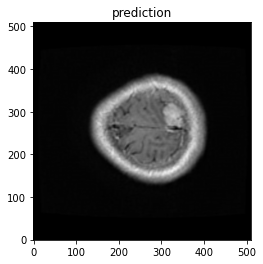

100/100 - 6s - loss: 0.0037 - val_loss: 0.0010
Epoch 2/100
Mean PSNR for epoch: 31.08
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 4s - loss: 8.3268e-04 - val_loss: 8.0148e-04
Epoch 3/100
Mean PSNR for epoch: 31.54
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 4s - loss: 7.2407e-04 - val_loss: 7.0711e-04
Epoch 4/100
Mean PSNR for epoch: 31.67
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 4s - loss: 6.7534e-04 - val_loss: 6.5438e-04
Epoch 5/100
Mean PSNR for epoch: 32.02
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 4s - loss: 6.2752e-04 - val_loss: 6.3002e-04
Epoch 6/100
Mean PSNR for epoch: 32.23
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 4s - loss: 5.9579e-04 - val_loss: 5.9491e-04
Epoch 7/100
Mean PSNR for epoch: 32.34
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 4s - loss: 5.7329e-04 - val_loss

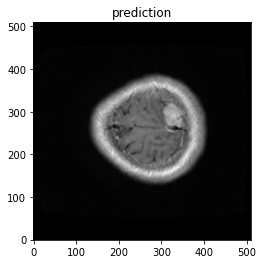

100/100 - 4s - loss: 5.0097e-04 - val_loss: 5.0188e-04
Epoch 22/100
Mean PSNR for epoch: 32.90
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 4s - loss: 4.9654e-04 - val_loss: 4.9771e-04
Epoch 23/100
Mean PSNR for epoch: 32.90
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 4s - loss: 4.7346e-04 - val_loss: 4.9120e-04
Epoch 24/100
Mean PSNR for epoch: 33.01
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 4s - loss: 4.7357e-04 - val_loss: 4.9190e-04
Epoch 25/100
Mean PSNR for epoch: 33.08
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 4s - loss: 4.7304e-04 - val_loss: 4.8822e-04
Epoch 26/100
Mean PSNR for epoch: 33.16
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 4s - loss: 4.8047e-04 - val_loss: 4.8529e-04
Epoch 27/100
Mean PSNR for epoch: 33.06
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 4s - loss: 4.6899e

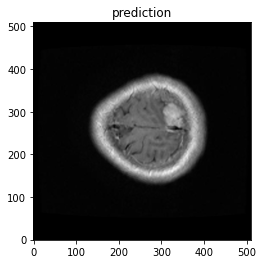

100/100 - 4s - loss: 4.7102e-04 - val_loss: 4.7114e-04
Epoch 42/100
Mean PSNR for epoch: 32.98
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 4s - loss: 4.5547e-04 - val_loss: 4.7038e-04
Epoch 43/100
Mean PSNR for epoch: 33.07
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 4s - loss: 4.5421e-04 - val_loss: 4.7532e-04
Epoch 44/100
Mean PSNR for epoch: 33.13
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 4s - loss: 4.5856e-04 - val_loss: 4.7868e-04
Epoch 45/100
Mean PSNR for epoch: 32.66
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 4s - loss: 4.5720e-04 - val_loss: 5.2392e-04
Epoch 46/100
Mean PSNR for epoch: 33.18
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 4s - loss: 4.5986e-04 - val_loss: 4.6623e-04
Epoch 47/100
Mean PSNR for epoch: 33.08
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 4s - loss: 4.5012e

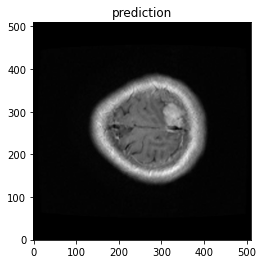

100/100 - 4s - loss: 4.4101e-04 - val_loss: 4.5957e-04
Epoch 62/100
Mean PSNR for epoch: 33.30
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 4s - loss: 4.4091e-04 - val_loss: 4.5962e-04
Epoch 63/100
Mean PSNR for epoch: 33.28
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 4s - loss: 4.3991e-04 - val_loss: 4.5807e-04
Epoch 64/100
Mean PSNR for epoch: 33.19
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 6s - loss: 4.3996e-04 - val_loss: 4.5877e-04
Epoch 65/100
Mean PSNR for epoch: 33.39
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 5s - loss: 4.4132e-04 - val_loss: 4.6148e-04
Epoch 66/100
Mean PSNR for epoch: 33.26
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 5s - loss: 4.4524e-04 - val_loss: 4.6616e-04
Epoch 67/100
Mean PSNR for epoch: 33.37
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 5s - loss: 4.3865e

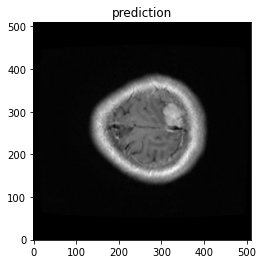

100/100 - 5s - loss: 4.3657e-04 - val_loss: 5.2844e-04
Epoch 82/100
Mean PSNR for epoch: 33.35
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 4s - loss: 4.4534e-04 - val_loss: 4.5253e-04
Epoch 83/100
Mean PSNR for epoch: 33.46
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 5s - loss: 4.3325e-04 - val_loss: 4.5385e-04
Epoch 84/100
Mean PSNR for epoch: 33.31
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 4s - loss: 4.3207e-04 - val_loss: 4.5361e-04
Epoch 85/100
Mean PSNR for epoch: 33.37
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 4s - loss: 4.3665e-04 - val_loss: 4.5118e-04
Epoch 86/100
Mean PSNR for epoch: 33.40
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 4s - loss: 4.4087e-04 - val_loss: 4.5780e-04
Epoch 87/100
Mean PSNR for epoch: 33.36
Average Mean Squared Error for epoch: nan
Mean SSIM for epoch: nan
100/100 - 4s - loss: 4.6452e

In [12]:
epochs = 100

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

### Now we run the model prediction and plot the results

PSNR of low resolution image and high resolution image is 39.7810
PSNR of predict and high resolution is 40.7129
Mean Squared Error of predict and high resolution is 6.8388
SSIM of predict and high resolution is 0.7841


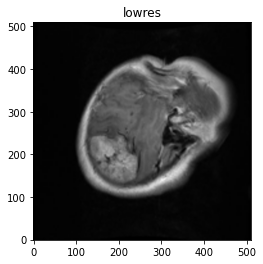

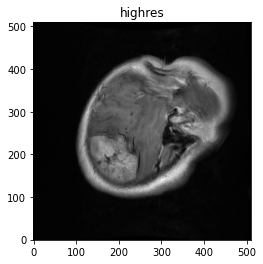

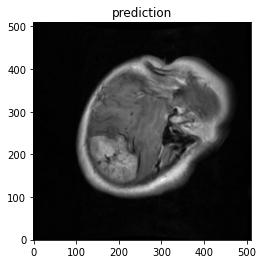

PSNR of low resolution image and high resolution image is 35.4438
PSNR of predict and high resolution is 37.6772
Mean Squared Error of predict and high resolution is 18.5654
SSIM of predict and high resolution is 0.8189


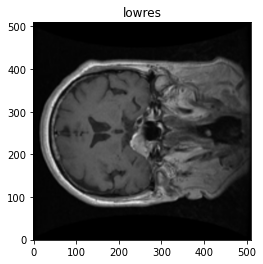

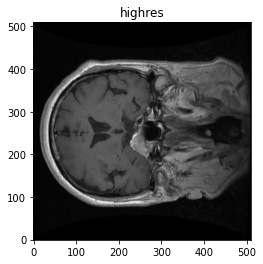

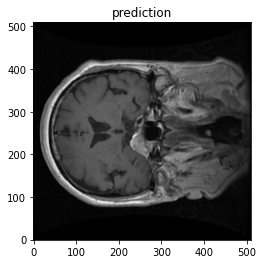

PSNR of low resolution image and high resolution image is 36.2027
PSNR of predict and high resolution is 39.1056
Mean Squared Error of predict and high resolution is 15.5889
SSIM of predict and high resolution is 0.8443


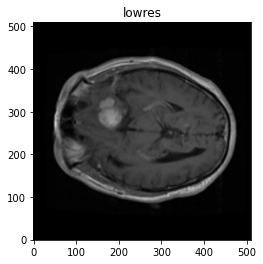

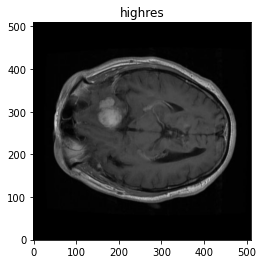

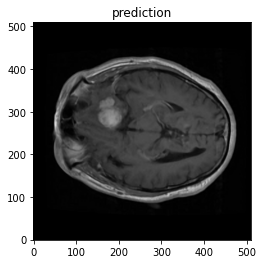

PSNR of low resolution image and high resolution image is 38.6647
PSNR of predict and high resolution is 39.7837
Mean Squared Error of predict and high resolution is 8.8432
SSIM of predict and high resolution is 0.8166


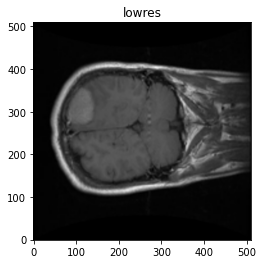

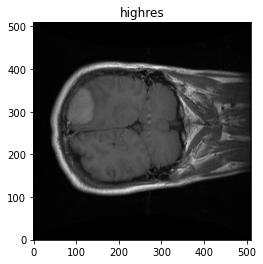

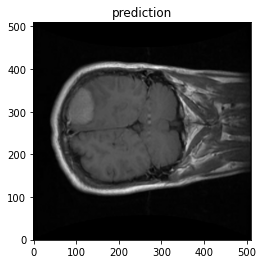

PSNR of low resolution image and high resolution image is 36.6647
PSNR of predict and high resolution is 39.1549
Mean Squared Error of predict and high resolution is 14.0154
SSIM of predict and high resolution is 0.8378


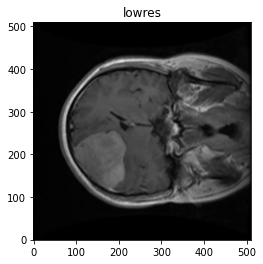

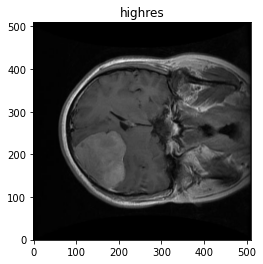

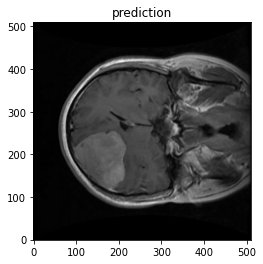

PSNR of low resolution image and high resolution image is 36.1015
PSNR of predict and high resolution is 38.4174
Mean Squared Error of predict and high resolution is 15.9563
SSIM of predict and high resolution is 0.8047


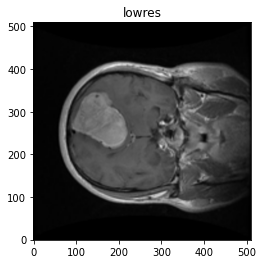

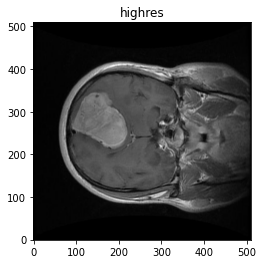

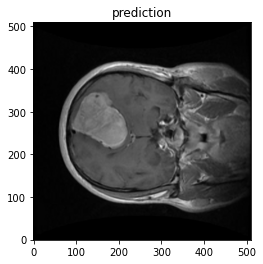

PSNR of low resolution image and high resolution image is 36.9125
PSNR of predict and high resolution is 39.0929
Mean Squared Error of predict and high resolution is 13.2382
SSIM of predict and high resolution is 0.8239


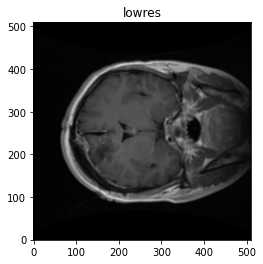

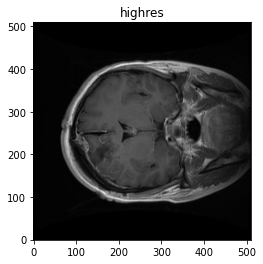

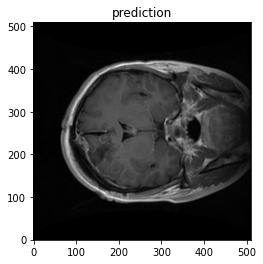

PSNR of low resolution image and high resolution image is 35.3972
PSNR of predict and high resolution is 38.3375
Mean Squared Error of predict and high resolution is 18.7653
SSIM of predict and high resolution is 0.8374


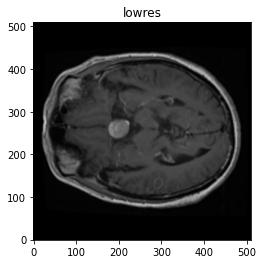

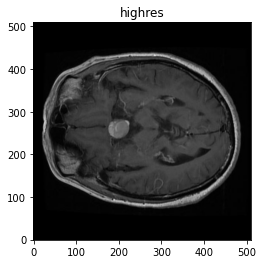

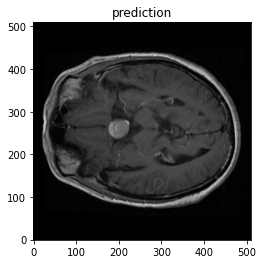

PSNR of low resolution image and high resolution image is 35.2505
PSNR of predict and high resolution is 38.0587
Mean Squared Error of predict and high resolution is 19.4102
SSIM of predict and high resolution is 0.8024


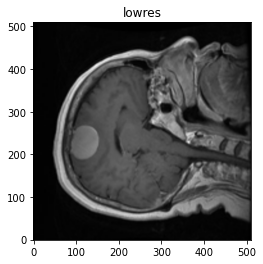

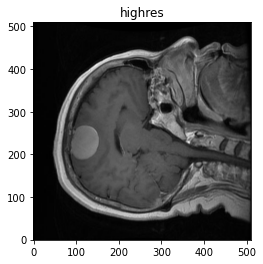

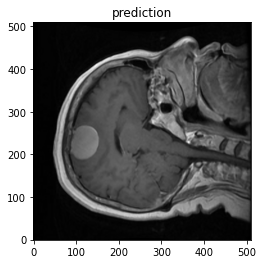

PSNR of low resolution image and high resolution image is 37.0542
PSNR of predict and high resolution is 38.2715
Mean Squared Error of predict and high resolution is 12.8132
SSIM of predict and high resolution is 0.7486


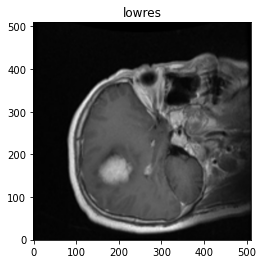

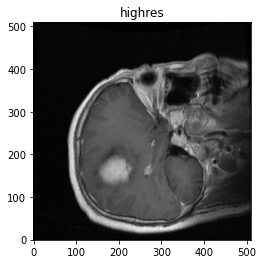

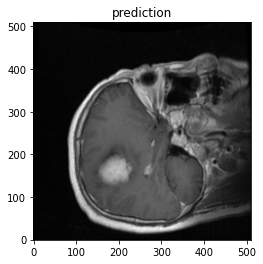

Avg. PSNR of lowres images is 36.7473
Avg. PSNR of reconstructions is 38.8612
Avg. MSE of reconstructions is 14.4035
Avg. SSIM of reconstructions is 0.8119


In [15]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0
total_test_ssim = 0.0
total_test_mse = 0.0

for index, test_img_path in enumerate(test_img_paths[35:45]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)
    test_mse = mse(lowres_img_arr, highres_img_arr)
    test_ssim = ssim(lowres_img_arr, highres_img_arr, multichannel=True)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr
    total_test_ssim += test_ssim
    total_test_mse += test_mse

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    print("Mean Squared Error of predict and high resolution is %.4f" % test_mse)
    print("SSIM of predict and high resolution is %.4f" % test_ssim)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))
print("Avg. MSE of reconstructions is %.4f" % (total_test_mse / 10))
print("Avg. SSIM of reconstructions is %.4f" % (total_test_ssim / 10))